<a href="https://colab.research.google.com/github/pvanand07/NIFTY50-Daily-Trend-Prediction-Using-NLP-Python/blob/master/NIFTY50_Prediction_Twitter_NLP_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NIFTY 50 PREDICTION USING TWEETS

## This Notebook tries to obtain the sentiment of twitter users and predict the trends in stock market by scraping tweets using `snscrape` and running sentiment analysis using `Textblob` and `FinBERT`

## 1.1 Setup for Google Collab
1. Install snscrape and transformers

In [1]:
# Install snscrape library for webscraping
!pip3 install snscrape;
# Install transformers library
!pip install transformers;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 KB 2.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.4 MB/s eta 0:00:00


## 1.2 Import Necessory Libraries

In [2]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from transformers import pipeline
from textblob import TextBlob
from tqdm import tqdm
from collections import Counter

# Import finbert model
classifier = pipeline('sentiment-analysis', model="ProsusAI/finbert")

## 1.3 Obtaining Tweets

In [4]:
# Define the keyword and the number of tweets to scrape
QUERY = 'nifty50'
N_TWEETS = 500

# Create an empty list to store the attributes of the tweets
attributes_container = []

# Scrape the tweets and extract the specified attributes
for i, tweet in tqdm(
    enumerate(sntwitter.TwitterSearchScraper(QUERY).get_items()), total=N_TWEETS
):
    if i > N_TWEETS:
        break
    # Store necessory data for sentiment analysis
    attributes_container.append(
        [   tweet.date,
            tweet.likeCount,
            tweet.content,
            tweet.hashtags,
        ]
    )

# Create a dataframe from the attributes list
tweets_df = pd.DataFrame(
    attributes_container,
    columns=[
        "Date_Created",
        "Like_Count",
        "tweet_Content",
        "Hashtags",
    ],
)

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-4-694ad775c336>:18: DeprecatedFeatureWarning: content is deprecated, use rawContent instead
  tweet.content,
501it [00:20, 24.04it/s]                         


## 2. Generating Wordcloud

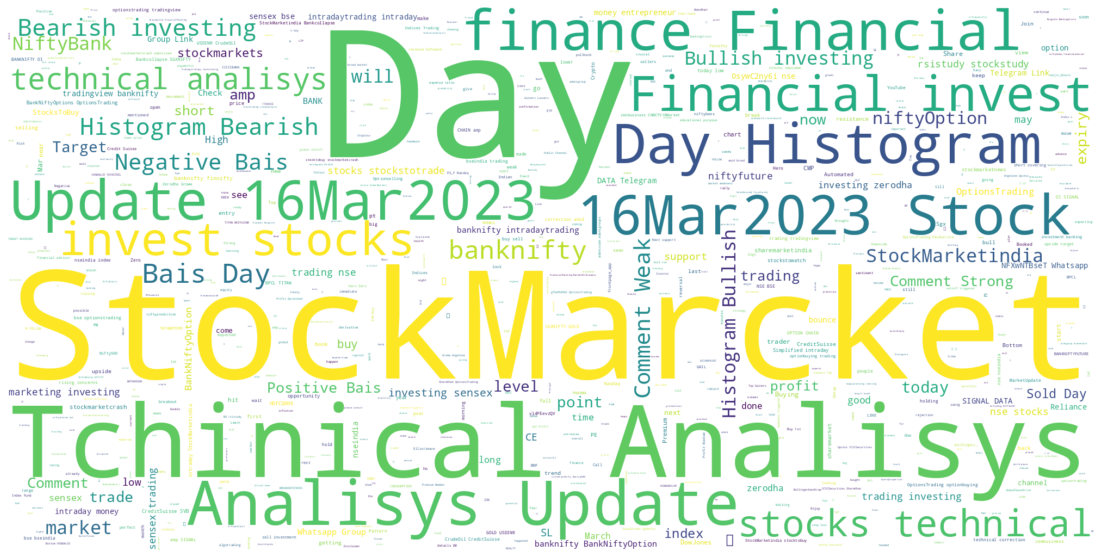

In [5]:
# Create a string of all the tweets
tweets_string = ' '.join(tweets_df['tweet_Content'])

# Create a set of stopwords
stopwords = set(STOPWORDS)
stopwords.update(["RT","https","co","nifty50","min","RSI","nifty","stockmarket","t","finantial","Analysis","business",":","30"])

# Create a word cloud object
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white",
                      width=2000,
                      height=1000,
                      max_words=1000,
                      contour_width=3,
                      contour_color='steelblue').generate(tweets_string)

# Plot the word cloud
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 2.1 Sentiment Analysis Using TextBlob

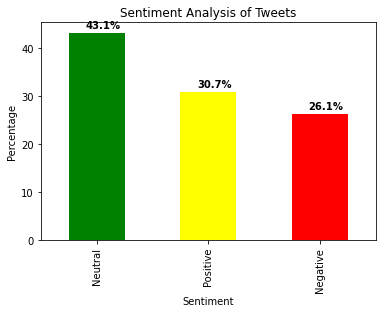

In [6]:
# Add a new column to the dataframe to store the sentiment
tweets_df['Sentiment'] = tweets_df['tweet_Content'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Create a new column to categorize the sentiment as positive, neutral or negative
tweets_df['Sentiment_Category'] = tweets_df['Sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Neutral' if x == 0 else 'Negative')

# Calculate the percentage of each sentiment category
sentiment_counts = tweets_df['Sentiment_Category'].value_counts(normalize=True) * 100

# Create a bar plot of the sentiment category with percentage values on top of bars
ax = sentiment_counts.plot(kind='bar', color=['green', 'yellow', 'red'])
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage')
ax.set_title('Sentiment Analysis of Tweets')

# Add percentage values on top of bars
for i, v in enumerate(sentiment_counts):
    ax.text(i - 0.1, v + 1, f'{v:.1f}%', color='black', fontweight='bold')

plt.show()


In [7]:
tweets_df['Sentiment_Category'].value_counts()*100/len(tweets_df)

Neutral     43.113772
Positive    30.738523
Negative    26.147705
Name: Sentiment_Category, dtype: float64

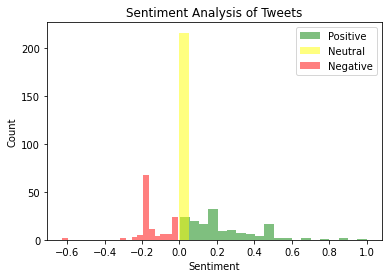

In [8]:
# Create a histogram of the sentiment
plt.hist(tweets_df[tweets_df['Sentiment'] > 0]['Sentiment'], bins=20, color='green', alpha=0.5, label='Positive')
plt.hist(tweets_df[tweets_df['Sentiment'] == 0]['Sentiment'], bins=20, color='yellow', alpha=0.5, label='Neutral')
plt.hist(tweets_df[tweets_df['Sentiment'] < 0]['Sentiment'], bins=20, color='red', alpha=0.5, label='Negative')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend()
plt.title('Sentiment Analysis of Tweets')
plt.show()

## 2.2 Sentiment Analysis Using FinBERT

100%|██████████| 501/501 [02:53<00:00,  2.88it/s]


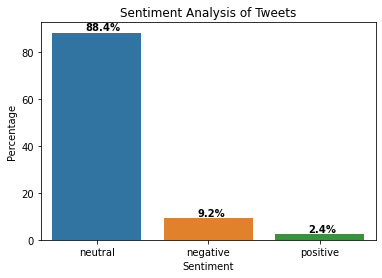

In [9]:
# Add a new column to the dataframe to store the sentiment
tweets_df['Sentiment'] = [classifier(x)[0]['label'] for x in tqdm(tweets_df['tweet_Content'])]

# Count the number of tweets for each sentiment
counts = tweets_df['Sentiment'].value_counts()

# Calculate the percentage of each sentiment category
sentiment_counts = counts / len(tweets_df) * 100

# Plot the sentiment counts using a bar plot with percentage values on top of bars
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage')
ax.set_title('Sentiment Analysis of Tweets')

# Add percentage values on top of bars
for i, v in enumerate(sentiment_counts):
    ax.text(i - 0.1, v + 1, f'{v:.1f}%', color='black', fontweight='bold')

# Show the plot
plt.show()

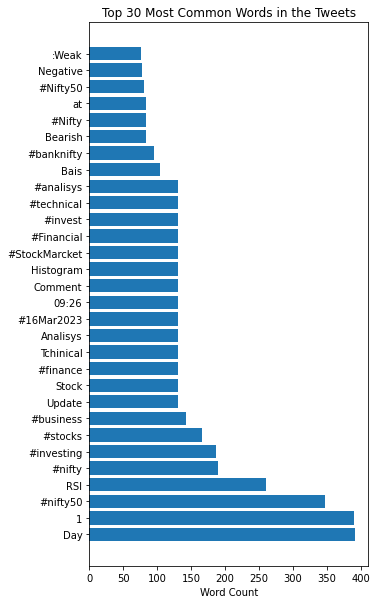

In [10]:
# Create a list of all the words in the tweets
words_list = ' '.join(tweets_df['tweet_Content']).split()
unwanted_words = ['the', 'and', 'is', 'in', 'to', 'of', 'it', 'with', 'for', 'on',':','30',"RT","https","co","nifty50","min","RSI","nifty","stockmarket","t","finantial","Analysis","business",]

# Use a list comprehension to remove the unwanted words from the original list
filtered_words = [word for word in words_list if word.lower() not in unwanted_words]
# Count the frequency of each word
word_counts = Counter(filtered_words)

# Get the top 10 most common words
top_words = word_counts.most_common(30)
plt.figure(figsize=(5,10))
# Create a horizontal bar plot of the word counts
plt.barh(range(len(top_words)), [count for _,count in top_words], align='center')
plt.yticks(range(len(top_words)), [word for word, _ in top_words])
plt.xlabel('Word Count')
plt.title('Top 30 Most Common Words in the Tweets')
plt.show()

## Extras

In [11]:
# Sample FinBERT Classifier Output
classifier("We hope you don't hate it.")

[{'label': 'neutral', 'score': 0.7994503974914551}]